In [1]:
import linearsolver as ls
import numpy as np
import matplotlib.pyplot as plt


n = 200
A_ = np.random.normal(size=(n**2)).reshape(n, n)
A = A_.T @ A_
# A = np.array(
#     [
#         [3, 0, -1, -1, 0, -1],
#         [0, 2, 0, -1, 0, 0],
#         [-1, 0, 3, 0, -1, 0],
#         [-1, -1, 0, 2, 0, -1],
#         [0, 0, -1, 0, 3, 1],
#         [-1, 0, 0, -1, -1, 4],
#     ],
#     dtype=float,
# )

x = np.random.normal(size=n)
x0 = np.random.normal(size=n)
b = A @ x
print(np.linalg.cond(A))
x_cg, res = ls.conjGrad(A, x0, b, 1e-7, 3*n, True)
((x_cg - x)**(2)).mean()

2065271.0648157198
Condition number of A: 2065271.0648157198
It:    20, ||r|| = 19.143228261914857
It:    40, ||r|| = 4.5132884761394205
It:    60, ||r|| = 2.694931827002252
It:    80, ||r|| = 1.2560200864090598
It:   100, ||r|| = 0.7839161290453447
It:   120, ||r|| = 0.46865651334043584
It:   140, ||r|| = 0.20070664239861627
It:   160, ||r|| = 0.13347690326070263
It:   180, ||r|| = 0.12105335552182277
It:   200, ||r|| = 0.09006338541912515
It:   220, ||r|| = 0.04687348020819369
It:   240, ||r|| = 0.017676886791279937
It:   260, ||r|| = 0.006342368174866856
It:   280, ||r|| = 0.002728705508904571
It:   300, ||r|| = 0.004719851370138521
It:   320, ||r|| = 0.004943738518289824
It:   340, ||r|| = 0.00778541385928357
It:   360, ||r|| = 0.000690508399996449
It:   380, ||r|| = 7.673849508655353e-07
It:   392, ||r|| = 9.693221104194475e-08


4.860140097196183e-18

## Deflation

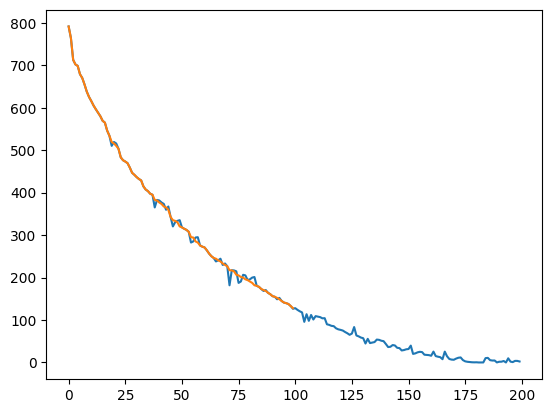

In [2]:
U, S, VT = np.linalg.svd(A)
r= n //2 
Ur, Sr, Vr = U[:, :r], S[:r], VT.T[:, :r]

w, v = np.linalg.eig(A)
plt.plot(w)
plt.plot(Sr)

In [3]:
def proj(Ur, Sr):
    projector = Ur @ Ur.T
    sec = Ur @ np.diag(Sr**(-1)) @ Ur.T
    return projector, sec

pi_A,  pi_U = proj(Ur, Sr)
maxiter=  10*n
second_term = pi_U @ b
pi_A_orth = np.eye(n) - pi_A
A_matrix = A @ pi_A_orth
x_cg_baseline = ls.solve_cg(A, b, maxiter=maxiter, verbose=True)[0]
x_cg_def_lhs = ls.solve_cg(A_matrix, pi_A_orth.T @ b, maxiter=maxiter, verbose=True)[0]
x_cg_def = pi_A_orth @ x_cg_def_lhs + pi_U @ b
print(((x_cg_def - x_cg_baseline)**2).sum())

Condition number of A: 2065271.0648157198
It:    20, ||r|| = 17.41185004863177
It:    40, ||r|| = 6.241793495584049
It:    60, ||r|| = 2.5385701182205107
It:    80, ||r|| = 1.839714675966386
It:   100, ||r|| = 0.8815442366032202
It:   120, ||r|| = 0.5973567021669903
It:   140, ||r|| = 0.2281357622461701
It:   160, ||r|| = 0.3047107942311247
It:   180, ||r|| = 0.11416267242409961
It:   200, ||r|| = 0.21601399712879285
It:   220, ||r|| = 0.05784703634935366
It:   240, ||r|| = 0.08246471877533079
It:   260, ||r|| = 0.11529397425657469
It:   280, ||r|| = 0.06673584685531238
It:   300, ||r|| = 0.03322391060355591
It:   320, ||r|| = 0.022308319173015262
It:   340, ||r|| = 6.782492247477122e-05
It:   360, ||r|| = 8.292726987633733e-05
It:   380, ||r|| = 7.971731096895316e-08
It:   393, ||r|| = 8.73830213773345e-09
Condition number of A: 6.9458443343969464e+16
It:    20, ||r|| = 2.3056204447597537
It:    40, ||r|| = 0.577874996514957
It:    60, ||r|| = 0.17302247185497152
It:    80, ||r|| = 0.

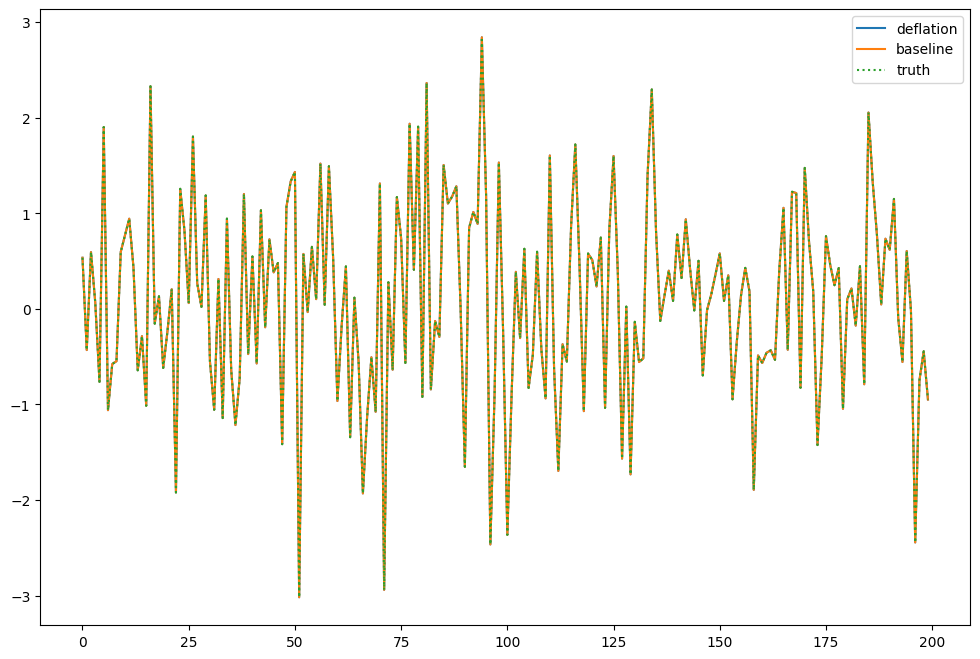

In [4]:
plt.figure(figsize=(12,8))
plt.plot(x_cg_def, label='deflation')
plt.plot(x_cg_baseline, label='baseline')
plt.plot(x, ':', label='truth')
plt.legend()

In [5]:
print(f"{(pi_A_orth @ x - pi_A_orth @ x_cg_def_lhs).max()=}")
print(f"{(pi_A @ x - pi_U @ b).max()=}")

(pi_A_orth @ x - pi_A_orth @ x_cg_def_lhs).max()=1.7588464018558625e-10
(pi_A @ x - pi_U @ b).max()=3.1086244689504383e-15


## spectral LMP ?

In [6]:
U, S, VT = np.linalg.svd(A)
r= n //2 
Ur, Sr, Vr = U[:, :r], S[:r], VT.T[:, :r]
Ur = Ur + 0.001*np.random.normal(size=Ur.shape)
Sr = Sr +  2*np.random.normal(size=Sr.shape)
# Ur = Ur + 0.001*np.random.normal(size=Ur.shape)


In [7]:
def sum_lmp_spectral(S, U, r):
    acc = np.zeros((n,n))
    for i in range(r):
        acc += (1- (1/S[i])) * U[:, i].reshape(n, 1) @ U[:, i].reshape(1, n)
    return np.eye(n) - acc

In [8]:
H_r = sum_lmp_spectral(Sr, Ur, r)
x_cg_baseline = ls.solve_cg(A, b, maxiter=maxiter, verbose=True)[0]
x_cg_lmp = ls.solve_cg(H_r @ A, H_r @ b, maxiter=maxiter, verbose=True)[0]

Condition number of A: 2065271.0648157198
It:    20, ||r|| = 17.41185004863177
It:    40, ||r|| = 6.241793495584049
It:    60, ||r|| = 2.5385701182205107
It:    80, ||r|| = 1.839714675966386
It:   100, ||r|| = 0.8815442366032202
It:   120, ||r|| = 0.5973567021669903
It:   140, ||r|| = 0.2281357622461701
It:   160, ||r|| = 0.3047107942311247
It:   180, ||r|| = 0.11416267242409961
It:   200, ||r|| = 0.21601399712879285
It:   220, ||r|| = 0.05784703634935366
It:   240, ||r|| = 0.08246471877533079
It:   260, ||r|| = 0.11529397425657469
It:   280, ||r|| = 0.06673584685531238
It:   300, ||r|| = 0.03322391060355591
It:   320, ||r|| = 0.022308319173015262
It:   340, ||r|| = 6.782492247477122e-05
It:   360, ||r|| = 8.292726987633733e-05
It:   380, ||r|| = 7.971731096895316e-08
It:   393, ||r|| = 8.73830213773345e-09
Condition number of A: 2129509.231756732
It:    20, ||r|| = 568.5367567043063
It:    40, ||r|| = 484.0325869033098
It:    60, ||r|| = 478.25892728073933
It:    80, ||r|| = 477.63142

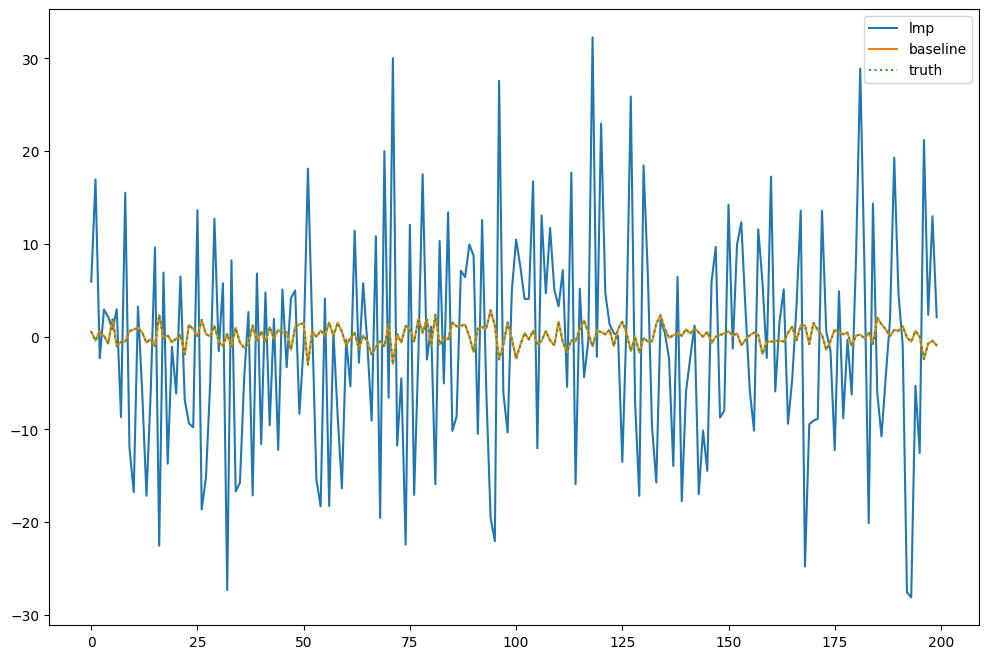

In [9]:
plt.figure(figsize=(12,8))
plt.plot(x_cg_lmp, label='lmp')
plt.plot(x_cg_baseline, label='baseline')
plt.plot(x, ':', label='truth')
plt.legend()

In [10]:
def bmm(a, b):
    return np.einsum("Bij,Bjk ->Bik", a, b)


def bt(a):
    return np.einsum("Bij->Bji", a)


def bouter(a, b):
    return np.einsum("Bnr,Bnr -> Bnn", a, b)


def bouter1D(a, b):
    return np.einsum("Bi,Bj -> Bij", a, b)


def bqr(a):
    Q = np.empty_like(a)
    for i, mat in enumerate(a):
        Q[i, ...] = np.linalg.qr(mat)[0]
    return Q


In [11]:
def construct_LMP(S: np.ndarray, AS: np.ndarray, shift: float = 1.0) -> np.ndarray:
    print(f"{S.shape=}")
    In = np.eye(S.shape[1]).reshape(1, S.shape[1], S.shape[1])
    StASm1 = np.linalg.inv(bmm(bt(S), AS))
    left = In - bmm(bmm(S, StASm1), bt(AS))
    mid = In - bmm(bmm(AS, StASm1), bt(S))
    right = bmm(bmm(S, StASm1), bt(S))
    H = bmm(left, mid) + shift * right
    return H


def construct_invLMP(S: np.ndarray, AS: np.ndarray, shift: float = 1.0) -> np.ndarray:
    print(f"{S.shape=}")

    In = np.eye(S.shape[1]).reshape(1, S.shape[1], S.shape[1])
    StASm1 = np.linalg.inv(bmm(bt(S), AS))
    B = (
        In
        + (1 / shift) * bmm(bmm(AS, StASm1), bt(AS))
        - bmm(
            bmm(S, np.linalg.inv(bmm(bt(S), S))),
            bt(S),
        )
    )
    return B

In [12]:
Ulmp = Ur + 0.1*np.random.normal(size=Ur.shape)
baselmp = construct_LMP(Ulmp[None, ...], A @ Ulmp[None, ...]).squeeze()
invlmp = construct_invLMP(Ulmp[None, ...], A @ Ulmp[None, ...]).squeeze()

S.shape=(1, 200, 100)
S.shape=(1, 200, 100)


In [13]:
r= 1
Ur, Sr, Vr = U[:, :r], S[:r], VT.T[:, :r]
Ulmp = Ur + 0.1*np.random.normal(size=Ur.shape)
AUlmp = A @ Ulmp 
baselmp = construct_LMP(Ulmp[None, ...], AUlmp[None, ...]).squeeze()
invlmp = construct_invLMP(Ulmp[None, ...], AUlmp[None, ...]).squeeze()
x_cg_baseline = ls.solve_cg(A, b, maxiter=200, verbose=True)
x_cg_lmp = ls.solve_cg(baselmp @ A, baselmp @ b, maxiter=200, verbose=True)

S.shape=(1, 200, 1)
S.shape=(1, 200, 1)
Condition number of A: 2065271.0648157198
It:    20, ||r|| = 17.41185004863177
It:    40, ||r|| = 6.241793495584049
It:    60, ||r|| = 2.5385701182205107
It:    80, ||r|| = 1.839714675966386
It:   100, ||r|| = 0.8815442366032202
It:   120, ||r|| = 0.5973567021669903
It:   140, ||r|| = 0.2281357622461701
It:   160, ||r|| = 0.3047107942311247
It:   180, ||r|| = 0.11416267242409961
It:   200, ||r|| = 0.21601399712879285
It:   200, ||r|| = 0.21601399712879285
Condition number of A: 1994148.5631244734
It:    20, ||r|| = 17.744843939767925
It:    40, ||r|| = 6.206116564125799
It:    60, ||r|| = 2.6141677567486865
It:    80, ||r|| = 1.7232344354599485
It:   100, ||r|| = 1.363246425005121
It:   120, ||r|| = 0.9129675272121236
It:   140, ||r|| = 0.5816469690232566
It:   160, ||r|| = 0.3241707558611113
It:   180, ||r|| = 0.325710949275766
It:   200, ||r|| = 0.2083102019716295
It:   200, ||r|| = 0.2083102019716295


Condition number of A: 2065271.0648157198
It:    10, ||r|| = 60.1591061868531
S.shape=(1, 200, 50)
S.shape=(1, 200, 50)
Condition number of A: 2065271.0648157198
It:    10, ||r|| = 39491.98481655306
S.shape=(1, 200, 50)
S.shape=(1, 200, 50)
Condition number of A: 2065271.0648157198
It:    10, ||r|| = 37029.95235223191
S.shape=(1, 200, 50)
S.shape=(1, 200, 50)
Condition number of A: 2065271.0648157198
It:    10, ||r|| = 49222.05794919026
S.shape=(1, 200, 50)
S.shape=(1, 200, 50)
Condition number of A: 2065271.0648157198
It:    10, ||r|| = 45422.77831286312
S.shape=(1, 200, 50)
S.shape=(1, 200, 50)
Condition number of A: 2065271.0648157198
It:    10, ||r|| = 45212.8451060527
S.shape=(1, 200, 50)
S.shape=(1, 200, 50)
Condition number of A: 2065271.0648157198
It:    10, ||r|| = 42651.96977722485
S.shape=(1, 200, 50)
S.shape=(1, 200, 50)
Condition number of A: 2065271.0648157198
It:    10, ||r|| = 40743.96450349157
S.shape=(1, 200, 50)
S.shape=(1, 200, 50)
Condition number of A: 2065271.064

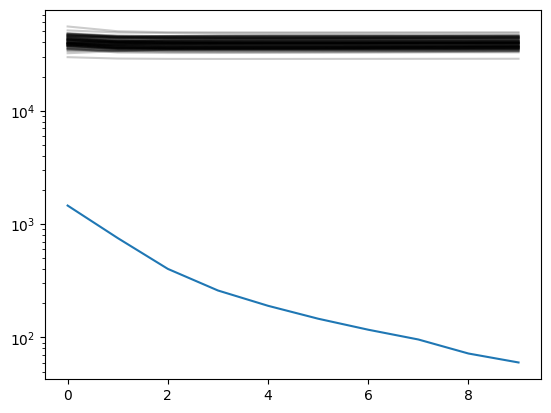

In [14]:
r= 50
Ur, Sr, Vr = U[:, :r], S[:r], VT.T[:, :r]
x_cg_baseline = ls.solve_cg(A, b, maxiter=10, verbose=True)
for i in range(100):
    Ulmp = Ur + 0.1*np.random.normal(size=Ur.shape)
    Ulmp = np.linalg.qr(Ulmp)[0]
    AUlmp = A @ Ulmp  + 0.1*np.random.normal(size=Ur.shape)
    baselmp = construct_LMP(Ulmp[None, ...], AUlmp[None, ...]).squeeze()
    invlmp = construct_invLMP(Ulmp[None, ...], AUlmp[None, ...]).squeeze()
    x_cg_lmp = ls.solve_prec_cg(A, b, baselmp, maxiter=maxiter, verbose=True)
    plt.plot(x_cg_lmp[1]['norm_res'], color='black', alpha=0.2)
plt.plot(x_cg_baseline[1]['norm_res'])
plt.yscale('log')

In [15]:
print((baselmp - H_r).min(), (baselmp - H_r).max())

-0.14436090668835866 0.5593223941308223
